In [115]:
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt
from emojihunt import *
import json
import matplotlib.pyplot as plt
import cv2

from google.colab.patches import cv2_imshow
import numpy as np

Current project version:
emojihunt==1.1.1


# Template For EmojiHunt Project!

## EmojiHunt()
This is your emojihunt environment class you will use it for generating problem images, testing your configuration and getting your final scores on the trials.
### EmojiHunt.get_config()
This returns the dictionary of the configuration for the EmojiHunt. You can change the booleans in this dictionary to make the problem harder or easier.
### EmojiHunt.update_config(dict)
This writes the passed dictionary as the new configuration for the EmojiHunt. It should be formated as recived from .get_config(). 
### EmojiHunt.generate_image_and_points()
This returns 3 objects the target image, the example emoji and the ground truth real points. This function is avalible so you can test your method without needing to perform full official tests. The emoji image and the test target image are simple cv2 formated color images (BGR, numpy uint8). The ground truth points are a list of tuples of points [(x_0,y_0)..(x_n,y_n)]
### EmojiHunt.generate_image_and_points(ground_truth, predicted)
This function gives the score between two sets of emoji points, the ground truth given by .generate_image_and_points() and the prediction points. 
### EmojiHunt.offical_test(function, config)
For this function you explicitly give a callable object (either fucntion or class method) that takes in the positional arguments of image, sample_emoji. This function then runs multiple tests on this function and prints a report based on the config and the socres. Official tests are seeded so the test for each config is always the same. 
### Examples of the usage of all these methods are given below.


In [116]:
emoji_hunt_object = EmojiHunt() 
transforms = {
  "emoji_transforms": {
    "Add": False,
    "Multiply": False,
    "Cutout": False,
    "CoarseDropout": False,
    "CoarseSaltAndPepper": False,
    "JpegCompression": False,
    "BlendAlpha": False,
    "BlendAlphaRegularGrid": False,
    "GaussianBlur": True,
    "MotionBlur": False,
    "MultiplyHueAndSaturation": False,
    "Grayscale": False,
    "ChangeColorTemperature": False,
    "SigmoidContrast": False,
    "CLAHE": False,
    "Emboss": False,
    "DirectedEdgeDetect": False,
    "Fliplr": False,
    "PiecewiseAffine": False,
    "PerspectiveTransform": False,
    "WithPolarWarping": False,
    "Rot90": False,
    "ElasticTransformation": False,
    "Jigsaw": False
  }
}
emoji_hunt_object.update_config(transforms)

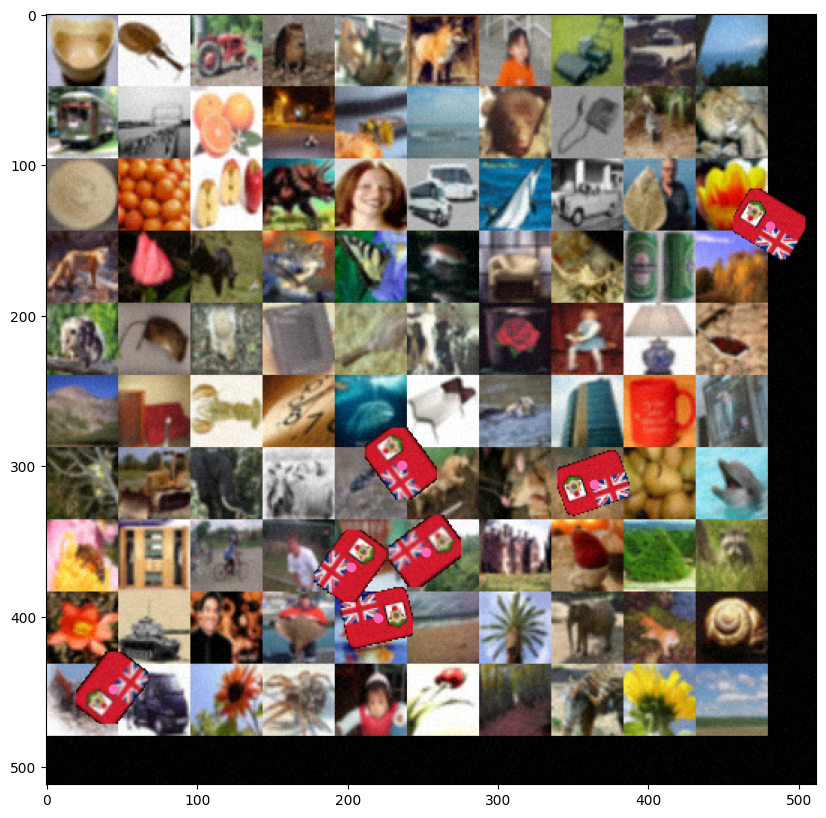

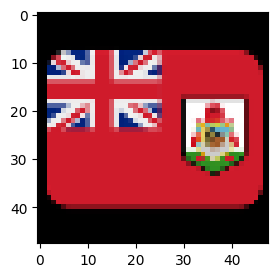

In [136]:
test_image, emoji_target, gt_points = emoji_hunt_object.generate_image_and_points()

plt.figure(figsize = (10,10))
imgplot = plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
x = [p[0] for p in gt_points]
y = [p[1] for p in gt_points]
plt.scatter(y, x, color="hotpink")
plt.show()
plt.figure(figsize = (3,3))
imgplot2 = plt.imshow(cv2.cvtColor(emoji_target, cv2.COLOR_BGR2RGB))
plt.show()

In [118]:
def segment_image(image):
  h, w = image.shape[:2]
  sub_h, sub_w = emoji_target.shape[:2]
  window = 6

  sub_images = []
  for y in range(0, h - sub_h, window):
    for x in range(0, w - sub_w, window):
      sub_image = image[y: y + sub_h, x: x + sub_w]
      centre_point = (int( y + (sub_h / 2)), int( x + (sub_w / 2)))
      sub_images.append((sub_image, centre_point))

  return sub_images

In [119]:
def compute_histogram(image):
  gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
  hist_size = 256
  hist_range = (0, 256)
  hist = cv2.calcHist([gray], [0], None, [hist_size], hist_range, accumulate=False)

  # Remove contribution of pixels with intensity 0
  hist[0] = 0

  return hist 

def plot_histogram(histogram):
  plt.plot(histogram, color="hotpink")
  plt.show()

def histogram_similarity(histogram1, histogram2):
  hist1_norm = cv2.normalize(histogram1, histogram1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  hist2_norm = cv2.normalize(histogram2, histogram2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  bhattacharyya = cv2.compareHist(hist1_norm, hist2_norm, cv2.HISTCMP_BHATTACHARYYA)

  return bhattacharyya

In [134]:
def bhatt_filter(image, emoji):
  emoji_hist = compute_histogram(emoji)
  sub_images = segment_image(image)

  bhatts = []
  for i in sub_images:
    hist = compute_histogram(i[0])
    score = histogram_similarity(emoji_hist.copy(), hist)
    bhatts.append(score)

  filtered = []
  min_score, max_score = min(bhatts), max(bhatts)

  factor = 0.4
  ratio = factor * (np.sqrt(max_score/min_score) - 1.0)
  for i, score in enumerate(bhatts):
    # Tolerance will need to be adjusted on a case-by-case basis
    if np.isclose(min_score, max_score, rtol=0.3):
      if np.isclose(score, min_score, rtol=ratio):
        filtered.append(sub_images[i])
    elif np.isclose(score, min_score, rtol=0.3):
        filtered.append(sub_images[i])

  return filtered

In [121]:
def non_max_suppression(keypoints, radius):
    keypoints = np.array(keypoints)
    selected_keypoints = []

    while len(keypoints) > 0:
        selected_keypoint = keypoints[0]
        selected_keypoints.append(selected_keypoint)

        distances = np.linalg.norm(keypoints - selected_keypoint, axis=1)

        mask = distances < radius

        keypoints = keypoints[~mask]

    return selected_keypoints

In [140]:
def sift_filter(image, emoji):
  sift = cv2.SIFT_create()
  kp = []

  ref = cv2.cvtColor(emoji, cv2.COLOR_BGR2GRAY)
  kp_ref, desc_ref = sift.detectAndCompute(ref, None)

  filtered = bhatt_filter(image, emoji)
  for img in filtered:
    ROI, point = img[0], img[1]
    ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)

    try:
      kp_ROI, desc_ROI = sift.detectAndCompute(ROI, None)
      assert len(kp_ROI) > 0
    except AssertionError:
      continue

    #print(f"len(kp_ref): {len(kp_ref)}, len(kp_ROI): {len(kp_ROI)}")

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc_ref, desc_ROI, k=2)

    good_matches = []

    max_length = max([match[0].distance for match in matches])
    min_length = min([match[0].distance for match in matches])
    ratio = np.sqrt(min_length / (min_length + max_length))

    try:
      for m, n in matches:
        # Tolerance will need to be adjusted on a case-by-case basis
        if m.distance < ratio * n.distance:
          good_matches.append([m])
          kp.append(point)
          #img3 = cv2.drawMatchesKnn(ref, kp_ref, ROI, kp_ROI, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
          #cv2_imshow(img3)
    except ValueError:
      pass

  suppressed = non_max_suppression(keypoints=kp, radius=48)
  selected_keypoints = [(p[0], p[1]) for p in suppressed]

  return selected_keypoints

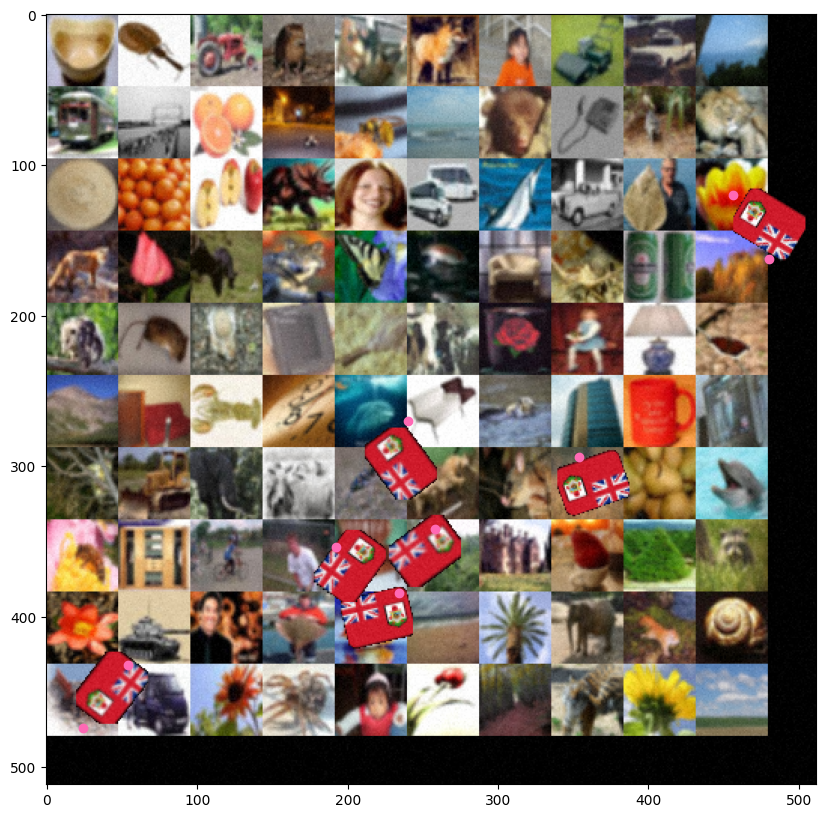

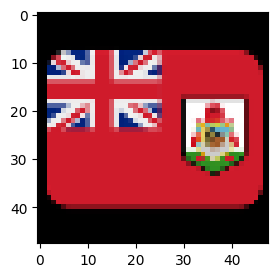

In [141]:
# Our results
selected_keypoints = sift_filter(test_image, emoji_target)
x = [p[0] for p in selected_keypoints]
y = [p[1] for p in selected_keypoints]

plt.figure(figsize = (10,10))
imgplot = plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.scatter(y, x, color="hotpink")
plt.show()
plt.figure(figsize = (3,3))
imgplot2 = plt.imshow(cv2.cvtColor(emoji_target, cv2.COLOR_BGR2RGB))
plt.show()

In [143]:
# Our score
emoji_hunt_object.offical_test(sift_filter, emoji_hunt_object.get_config())

~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     GaussianBlur
Scores (lower is better)....
    Run 0 -> 200.08399276888295
    Run 1 -> 266.51189802081433
    Run 2 -> 86.66169572368088
    Run 3 -> 232.0788696540344
    Run 4 -> 83.6877878098103
    Run 5 -> 183.77913300099212
    Run 6 -> 428.7418923981503
    Run 7 -> 314.1597979746447
    Run 8 -> 422.38904726371294
    Run 9 -> 129.9262144291163
    Run 10 -> 267.56778214723874
    Run 11 -> 430.65552299385143
    Run 12 -> 143.22757931257337
    Run 13 -> 152.79081962070848
    Run 14 -> 346.6898498199143
    Run 15 -> 13.918854664356985
    Run 16 -> 9.724148185031828
    Run 17 -> 439.3292913598736
    Run 18 -> 265.7373144762258
    Run 19 -> 237.3780908977868
    Run 20 -> 497.50692306063735
    Run 21 -> 448.27950849718746
    Run 22 -> 20.658351628684123
    Run 23 -> 289.8699890763342
    Run 24 -> 21.792277431317103
    Run 25 -> 360.740092408943
    Run 26 -> 80.87450361531454
    Run 27 -> 394.09021803530527
    